# Exercise 11.3
Import libraries and generate data

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt

def func(x):
  #  return np.sin(x[:,0]*x[:,1]+x[:,1]*x[:,1])
    v=[]
    for i in x:
        v.append(np.sin(i[0]*i[0]+i[1]*i[1]))
    return np.array(v)
# generate training inputs
np.random.seed(0)
X_train = np.random.uniform(-3/2, 3/2, (1000,2))

X_valid = np.random.uniform(-3/2, 3/2, (100,2))


y_target_train = func(X_train) 
y_target_valid = func(X_valid) 

sigma = 0.2 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(func(X_train), sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(func(X_valid), sigma)

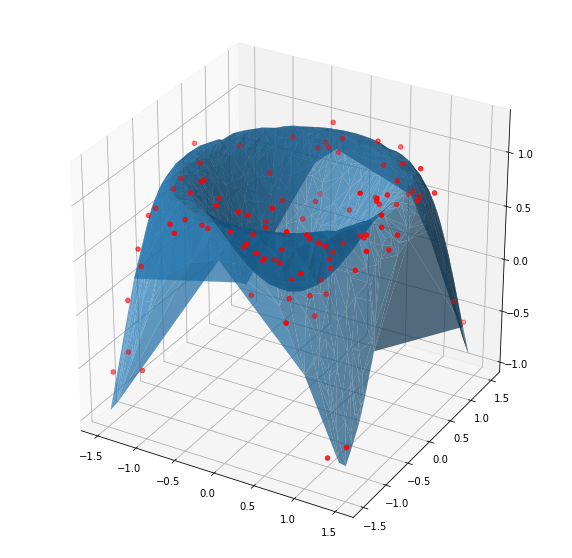

In [2]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#ax.contour(X_train[:,0], X_train[:,1], y_target_train)
#ax.plot_surface(X, Y, y_target_train.reshape(-1,1))
ax.plot_trisurf(X_train[:,0], X_train[:,1], y_target_train, alpha=0.7)
ax.scatter(X_valid[:,0], X_valid[:,1],  y_valid, c="r")

## Data preprocessing

Since the interval is not in a normal range, in this example, even more than in the others, data preprocessing is needed.

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_valid_scal = scaler.transform(X_valid)

## Building the model
Looking at the data, this time the model is not trivial as the linear regression. Furthermore at the border of the interval, data is quite steep. On this kind of data, using smooth function (as $sigmoid$ or $tanh$) usually performs very badly (the vanishing gradient problem) and the neural network after some point is not able to learn anything. A good choice is a nonlinear, not differentiable function as $relu$. On the output I will use a linear activation function in order to be able to predict all real values.

The problem space is quite more complex than in the previous exercises: in order to perform well, a deeper neural network is suitable. Furthermore, a "vanilla" stochastic gradient descent is too simple and would require too much "learning time" to find a convergence; indeed, an adaptive optimizer, as $adam$, should be much better. 

In [166]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LeakyReLU

model = keras.Sequential()
model.add(Dense(units=64, input_shape=(2,), activation="relu"))
model.add(Dense(units=64,activation="relu"))
model.add(Dense(units=1, activation="linear"))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='adam', loss='mse', metrics=['mse'], )

Since guessing the number of training ephocs is not simple and on this kind of data overfitting may be simple (lot of neurons, not much data), I will use the early stopping trick.

In [167]:
#since on this dataset is very easy to overfit, I use the early stopping
from tensorflow.contrib.keras.api.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,  patience=5, min_lr=0.001)
history = model.fit(x=X_train_scal, y=y_train, 
          batch_size=16, epochs=50,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(X_valid_scal, y_valid), callbacks=[es] )

Train on 1000 samples, validate on 100 samples
Epoch 1/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.2496 - mean_squared_error: 0.2496 - val_loss: 0.2068 - val_mean_squared_error: 0.2068
Epoch 2/50
1000/1000 [==============================] - 0s 238us/sample - loss: 0.1937 - mean_squared_error: 0.1937 - val_loss: 0.1796 - val_mean_squared_error: 0.1796
Epoch 3/50
1000/1000 [==============================] - 0s 225us/sample - loss: 0.1737 - mean_squared_error: 0.1737 - val_loss: 0.1752 - val_mean_squared_error: 0.1752
Epoch 4/50
1000/1000 [==============================] - 0s 215us/sample - loss: 0.1674 - mean_squared_error: 0.1674 - val_loss: 0.1648 - val_mean_squared_error: 0.1648
Epoch 5/50
1000/1000 [==============================] - 0s 236us/sample - loss: 0.1616 - mean_squared_error: 0.1616 - val_loss: 0.1441 - val_mean_squared_error: 0.1441
Epoch 6/50
1000/1000 [==============================] - 0s 242us/sample - loss: 0.1499 - mean_squared_error: 0.1499

As guessed the NN early stopped, let's analyze the result.

In [168]:
# evaluate model
score = model.evaluate(X_valid_scal, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
nn_perf=score[1]

100/100 [==============================] - 0s 113us/sample - loss: 0.0373 - mean_squared_error: 0.0373

Validation loss: 0.037313050031661986
Validation accuracy: 0.03731305


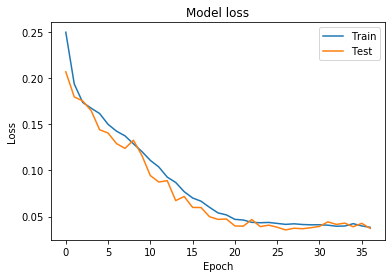

In [169]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

This graph is more interesting then the previous two: the loss on training is decreasing; accordingly the same is happening on the test but not as smooth: for the NN the two set are really different! We can see that at epochs 30 the loss of the training set is becoming lower than the one on test: now we must be very careful because overfitting from this point is easy. But keras understood this very well, and as soon as the neural network didn't learn anything useful for the test set it stopped the fitting (early stopping).

## Visualize the results

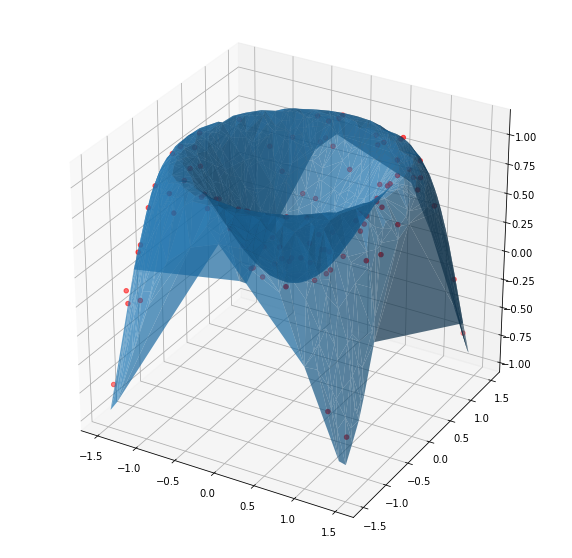

In [171]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

y_predicted=model.predict(X_valid_scal)
#ax.contour(X_train[:,0], X_train[:,1], y_target_train)
#ax.plot_surface(X, Y, y_target_train.reshape(-1,1))
ax.plot_trisurf(X_train[:,0], X_train[:,1], y_target_train, alpha=0.7)
ax.scatter(X_valid[:,0], X_valid[:,1],  y_predicted, c="r");

### Conclusion
Even if from this image is harder to tell then the previous models, I would say the neural netork performed well and the predictions are quite accurate.